In [33]:
import pandas as pd
import numpy as np
import os
import glob
import pickle
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

In [34]:
import powerlaw

In [35]:
from liquidity.util.feature_util import add_returns

In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load MO Data

In [37]:
tsla_df_mo = pd.read_csv('../../../../data/market_orders/TSLA-2016-R1.csv', header=0,index_col=0)
msft_df_mo = pd.read_csv('../../../../data/market_orders/MSFT-2016-R1.csv', header=0, index_col=0)
amzn_df_mo = pd.read_csv('../../../../data/market_orders/AMZN-2016-R1.csv', header=0, index_col=0)
nflx_df_mo = pd.read_csv('../../../../data/market_orders/NFLX-2016-R1.csv', header=0, index_col=0)
ebay_df_mo = pd.read_csv('../../../../data/market_orders/EBAY-2016-R1.csv', header=0, index_col=0)
appl_df_mo = pd.read_csv('../../../../data/market_orders/APPL-2016-R1.csv', header=0, index_col=0)

In [38]:
tsla_returns = add_returns(tsla_df_mo, pct=False, remove_first=True)['returns']
msft_returns = add_returns(msft_df_mo, pct=False, remove_first=True)['returns']
amzn_returns = add_returns(amzn_df_mo, pct=False, remove_first=True)['returns']
nflx_returns = add_returns(nflx_df_mo, pct=False, remove_first=True)['returns']
ebay_returns = add_returns(ebay_df_mo, pct=False, remove_first=True)['returns']
appl_returns = add_returns(appl_df_mo, pct=False, remove_first=True)['returns']

In [39]:
print(tsla_returns)

1         0.000
2        -0.095
3        -0.010
4        -0.090
5        -0.005
          ...  
757335   -0.005
757336   -0.045
757337    0.015
757338   -0.005
757339    0.035
Name: returns, Length: 757339, dtype: float64


In [40]:
all_stock_returns = {'TSLA': tsla_returns,
              'MSFT': msft_returns,
              'AMZN': amzn_returns,
              'NFLX': nflx_returns,
              'EBAY': ebay_returns,
              'APPL': appl_returns}

In [41]:
all_stock_returns

{'TSLA': 1         0.000
 2        -0.095
 3        -0.010
 4        -0.090
 5        -0.005
           ...  
 757335   -0.005
 757336   -0.045
 757337    0.015
 757338   -0.005
 757339    0.035
 Name: returns, Length: 757339, dtype: float64,
 'MSFT': 1          0.00
 2          0.00
 3          0.00
 4         -0.01
 5          0.00
            ... 
 1528301   -0.01
 1528302    0.01
 1528303    0.00
 1528304    0.01
 1528305    0.00
 Name: returns, Length: 1528305, dtype: float64,
 'AMZN': 1         -0.260
 2          0.000
 3          0.000
 4         -0.075
 5          0.000
            ...  
 1015007    0.000
 1015008    0.105
 1015009    0.035
 1015010    0.000
 1015011    0.095
 Name: returns, Length: 1015011, dtype: float64,
 'NFLX': 1         -0.010
 2         -0.030
 3         -0.015
 4         -0.015
 5          0.000
            ...  
 1631900    0.020
 1631901    0.015
 1631902    0.020
 1631903    0.025
 1631904    0.000
 Name: returns, Length: 1631904, dtype: float64,
 'E

In [42]:
print('Shape of feature vectors of each element')
for stock_name, return_series in all_stock_returns.items():
    print(return_series.shape)

Shape of feature vectors of each element
(757339,)
(1528305,)
(1015011,)
(1631904,)
(520484,)
(1411744,)


# 1. Fit Distributions and Visualise

## Fit return distributions for MO of different assets and save data

In [43]:
# Fit, plot, and save data to pickle
def fit_and_save(return_series, stock_name):
    filename = os.path.join(os.getcwd(), f'{stock_name}_fit.pkl')

    # Check if the file already exists
    if os.path.exists(filename):
        print(f"File {filename} already exists. Skipping.")
        return

    # If the fit object hasn't been saved, fit the model and save it
    fit = powerlaw.Fit(return_series.dropna(), discrete=False)

    data = {
        'data': return_series.dropna().tolist(),
        'xmin': fit.xmin,
        'xmax': fit.xmax
    }

    with open(filename, 'wb') as f:
        pickle.dump(data, f)

In [44]:
# Save data foreach each stock
for stock_name, return_series in all_stock_returns.items():
    fit_and_save(return_series, stock_name)

File /Users/ana_bugaenko/workspace/liquidity/notebooks/Experiments/market_orders/returns/TSLA_fit.pkl already exists. Skipping.
File /Users/ana_bugaenko/workspace/liquidity/notebooks/Experiments/market_orders/returns/MSFT_fit.pkl already exists. Skipping.
File /Users/ana_bugaenko/workspace/liquidity/notebooks/Experiments/market_orders/returns/AMZN_fit.pkl already exists. Skipping.
File /Users/ana_bugaenko/workspace/liquidity/notebooks/Experiments/market_orders/returns/NFLX_fit.pkl already exists. Skipping.
File /Users/ana_bugaenko/workspace/liquidity/notebooks/Experiments/market_orders/returns/EBAY_fit.pkl already exists. Skipping.
File /Users/ana_bugaenko/workspace/liquidity/notebooks/Experiments/market_orders/returns/APPL_fit.pkl already exists. Skipping.


### Retrieve data

In [45]:
# Load the essential data and recreate the Fit object
def load_fit_objects(stock_name=None):
    fit_objects = {}

    if stock_name:
        filename = os.path.join(os.getcwd(), f'{stock_name}_fit.pkl')
        with open(filename, 'rb') as f:
            data = pickle.load(f)
            fit = powerlaw.Fit(data['data'], xmin=data['xmin'], xmax=data['xmax'], discrete=False)
            fit_objects[stock_name] = fit
    else:
        for filename in glob.glob(os.path.join(os.getcwd(), '*_fit.pkl')):
            stock_name = os.path.basename(filename).split('_fit.pkl')[0]
            with open(filename, 'rb') as f:
                data = pickle.load(f)
            fit = powerlaw.Fit(data['data'], xmin=data['xmin'], xmax=data['xmax'], discrete=False)
            fit_objects[stock_name] = fit
    return fit_objects

In [46]:
# Import data from pickle into fit_objects
fit_objects = {}
fit_objects = load_fit_objects()

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


### Observe distributions

In [47]:
def plot_from_fit(fit, stock_name):
    # Create plots for the fit

    plt.figure(figsize=(15, 4))
    gs = gridspec.GridSpec(1, 4)
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])
    ax3 = plt.subplot(gs[0, 2])

    plt.suptitle(f'{stock_name}')

    # PDF
    fit.plot_pdf(color='b', linewidth=2, ax=ax1)
    ax1.set_title('PDF')
    ax1.grid(False)

    # CDF
    fit.plot_cdf(color='r', linewidth=2, ax=ax2)
    ax2.set_title('CDF')
    ax2.grid(False)

    # CCDF
    fit.plot_ccdf(color='g', linewidth=2, ax=ax3)
    ax3.set_title('CCDF')
    ax3.grid(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

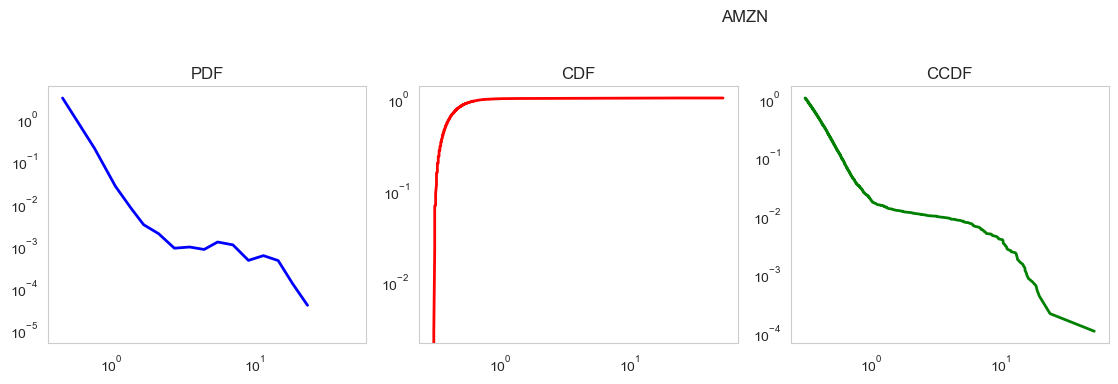

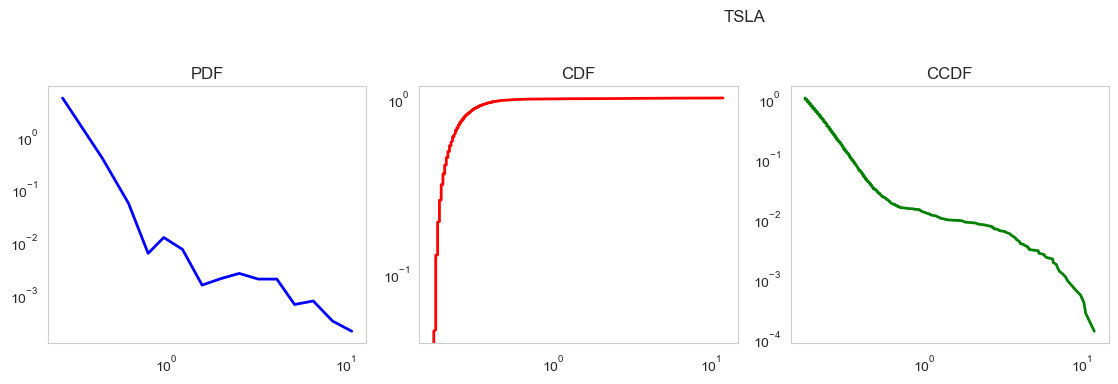

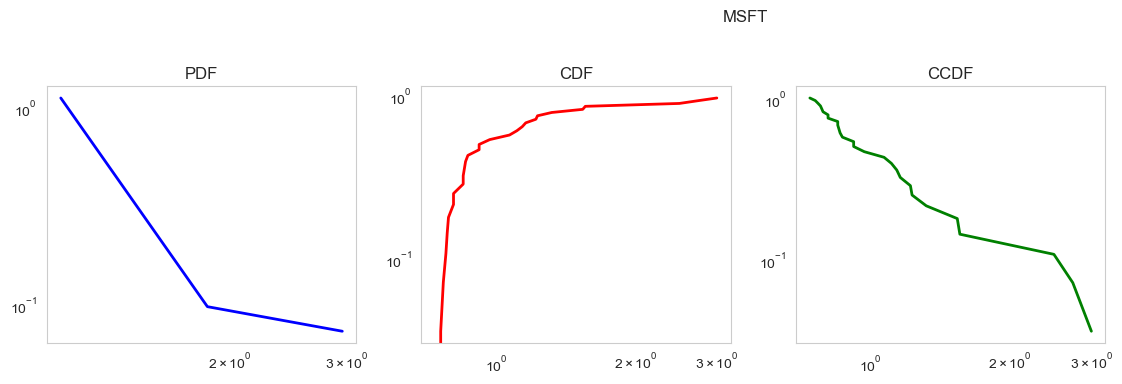

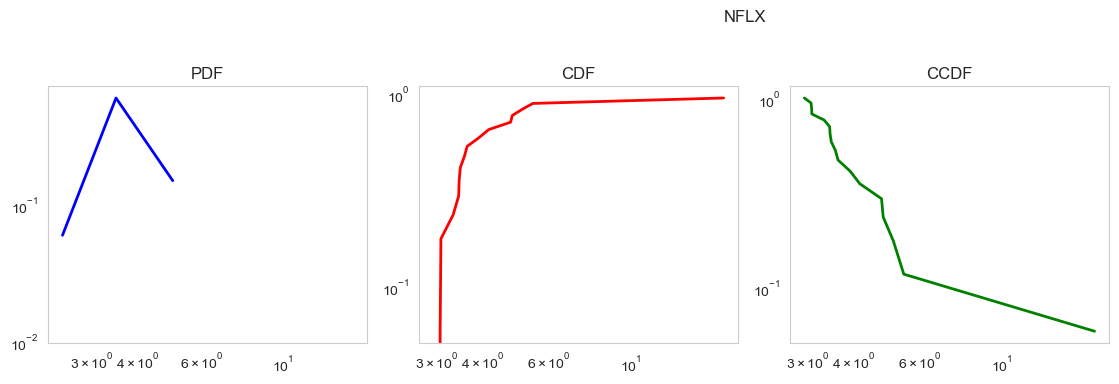

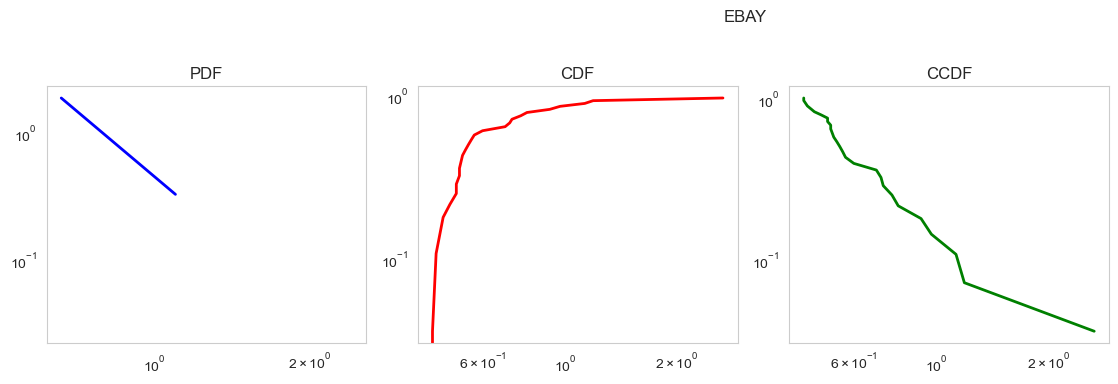

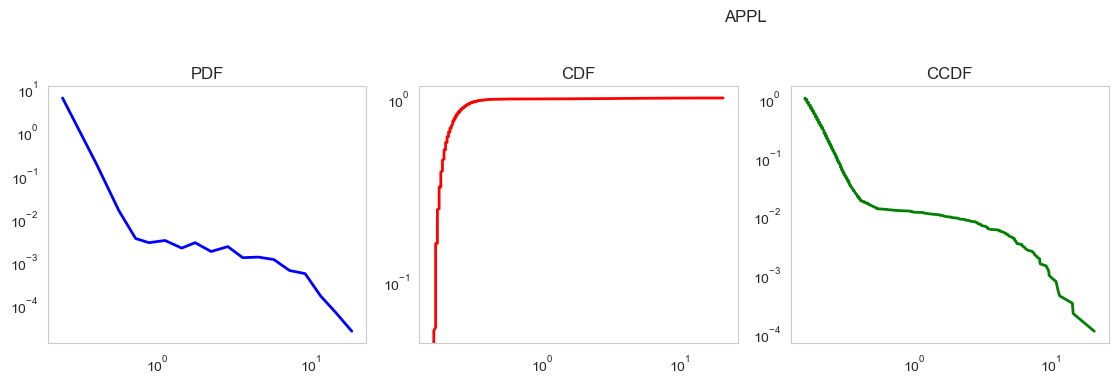

In [48]:
# Plot for each stock
for stock_name, fit in fit_objects.items():
    plot_from_fit(fit, stock_name)

#### PDF – Linear vs Logarithmic Bins

In [49]:
# TSLA example
data = fit_objects['TSLA']
data

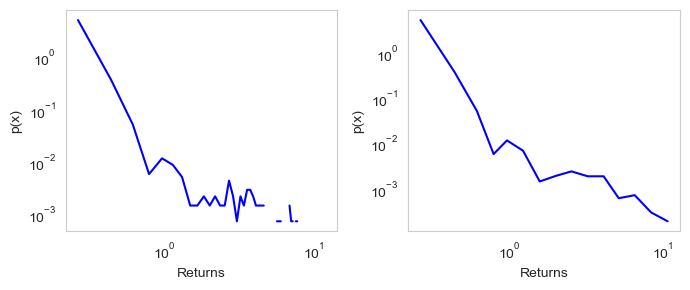

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
return_series = data

# Linear Spaced Bins
return_series.plot_pdf(color='b', linestyle='-', linear_bins=True, ax=axs[0])
axs[0].set_ylabel("p(x)")
axs[0].set_xlabel(r"Returns")
axs[0].grid(False)

# Logarithmically spaced bins
return_series.plot_pdf(color='b', linestyle='-', linear_bins=False, ax=axs[1])
axs[1].set_ylabel("p(x)")
axs[1].set_xlabel(r"Returns")
axs[1].grid(False)

plt.tight_layout()
plt.show()

#### CCDF – Logarithmic Bins

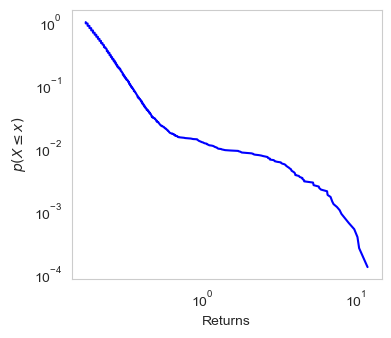

In [51]:
####  CCDFs do not require binning considerations
plt.figure(figsize=(4,3.5))
return_series = data
fidPDF = return_series.plot_ccdf(color='b', linestyle='-')
fidPDF.set_ylabel(r"$p(X \leq x)$")
fidPDF.set_xlabel(r"Returns")
fidPDF.grid(False)

## 1.1. Identify the scaling range xmin

In [52]:
# TSLA example
data = fit_objects['TSLA']

#### xmin
return_series = data
print('xmin:', return_series.xmin)

xmin: 0.17500000000001137


#### 1.2. Esitmate the scaling parameter alpha

In [53]:
#### alpha
print('Alpha:', return_series.alpha)

Alpha: 4.168749739049018


# 3. Comparing Candidate Distributions

## 3.1. Individual goodness of fit tests

#### KS- Distance

We use the Kolmogorov-Smirnov (KS) statistic D, which is simply the maximum distance between the CDFs of the data and the fitted model/fit, as a goodness-of-fit metric.</b>

This quantifies the distance between the empirical distribution of the data and the theoretical distribution suggested by the fitted model.


### Power law fit

In [54]:
# TSLA example
data = fit_objects['TSLA']

# parameter_range = {'alpha': [1, None]}
return_series = data # parameter_range=parameter_range

print('Alpha:', return_series.power_law.alpha)
print('KS Distance:', return_series.power_law.D)

Alpha: 4.168749739049018
KS Distance: 0.046951376382299306


### Exponential fit

In [55]:
print('Lambda:', return_series.exponential.parameter1)
print('KS Distance:', return_series.exponential.D)

Lambda: 9.242861439397684
KS Distance: 0.2035129360864275


### Lognormal (positive) fit

In [56]:
print('mu:', return_series.lognormal_positive.mu)
print('std:', return_series.lognormal_positive.parameter2)
print('KS Distance:', return_series.lognormal_positive.D)

mu: -1.4273874250265575
std: 0.38497400630560435
KS Distance: 0.9998713660921029


No valid fits found.


## 3.2.  Direct comparison of distributions

#### Likelihood Ratio

R is the loglikelihood ratio between the two candidate distributions. This number will be positive if the data is more likely in the first distribution, and negative if the data is more likely in the second distribution. In order to make a firm choice between distributions we need a log likelihood ratio that is sufficiently positive or negative that it could not plausibly be the result of a chance fluctuation from a true result that is close to zero.


Here, the p-value is used in a different context: comparing the likelihoods of two competing models (e.g., power-law vs. exponential) using a likelihood ratio test. p is the significance value for the direction of R. If this p-value is small (say p < 0.1) then it is unlikely that the observed sign is a chance. In this case, a low p-value indicates that the data is significantly more likely under one model than the other, meaning one model is a significantly better fit to the data than the other. However, if large, the sign is not reliable and the test does not favor either model.

#### Power law vs. Exponential fit

In [57]:
# TSLA example
data = fit_objects['TSLA']
return_series = data

print()
print('Power law')
print('Alpha:', return_series.power_law.alpha)
print('KS Distance:', return_series.power_law.D)

print()
print('Exponential')
print()
print('Lambda:', return_series.exponential.parameter1)
print('KS Distance:', return_series.exponential.D)

### The significance value for likely direction is p
print()
R, p = return_series.distribution_compare('power_law', 'exponential', normalized_ratio = True, nested=True)
print(f'Likelihood Ratio: {R}, p.value: {p}')


Power law
Alpha: 4.168749739049018
KS Distance: 0.046951376382299306

Exponential

Lambda: 9.242861439397684
KS Distance: 0.2035129360864275

Likelihood Ratio: 9.694855840874027, p.value: 0.0


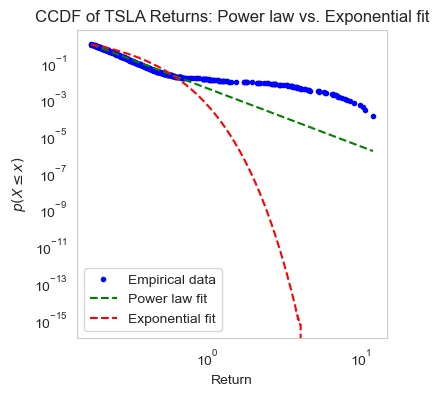

In [58]:
# Empirical CCDF data
empirical_data = return_series.ccdf()

# Power law fit
x = np.linspace(min(return_series.data), max(return_series.data), num=1000)
y_powerlaw = return_series.power_law.ccdf(x)

# Exponential fit
exponential_fit = powerlaw.Fit(return_series.data, discrete=False, xmin=min(return_series.data), estimate_discrete=False).exponential
y_exponential = exponential_fit.ccdf(x)

# Create plot
fig, ax = plt.subplots(figsize=(4, 4))

ax.loglog(empirical_data[0], empirical_data[1], 'b.', label='Empirical data')
ax.loglog(x, y_powerlaw, 'g--', label='Power law fit')
ax.loglog(x, y_exponential, 'r--', label='Exponential fit')

ax.set_title('CCDF of TSLA Returns: Power law vs. Exponential fit')
ax.set_xlabel('Return')
ax.set_ylabel(r"$p(X \leq x)$")
ax.legend()
ax.grid(False)

plt.show()

#### Power law vs. Lognormal (positive) fit

In [59]:
# TSLA example
data = fit_objects['TSLA']
return_series = data

print()
print('Power law')
print('Alpha:', return_series.power_law.alpha)
print('KS Distance:', return_series.power_law.D)

print()
print('Lognormal')
print()
print('mu:', return_series.lognormal_positive.mu)
print('std:', return_series.lognormal_positive.parameter2)
print('KS Distance:', return_series.lognormal_positive.D)


### The significance value for likely direction is p
print()
R, p = return_series.distribution_compare('power_law', 'lognormal_positive', normalized_ratio = True, nested=True)
print(f'Likelihood Ratio: {R}, p.value: {p}')


Power law
Alpha: 4.168749739049018
KS Distance: 0.046951376382299306

Lognormal

mu: -1.4273874250265575
std: 0.38497400630560435
KS Distance: 0.9998713660921029

Likelihood Ratio: 38923.256452113594, p.value: 0.0


No valid fits found.


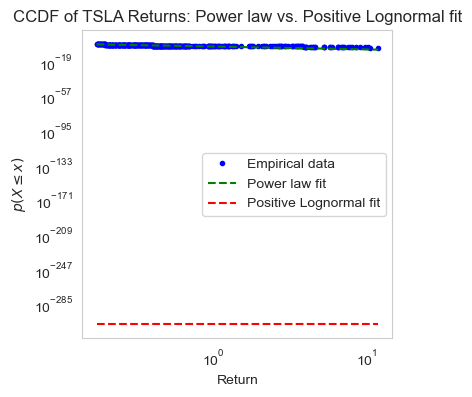

In [60]:
# Power law fit
x = np.linspace(min(return_series.data), max(return_series.data), num=1000)
y_powerlaw = return_series.power_law.ccdf(x)

# Positive lognormal fit
lognormal_positive_fit = powerlaw.Fit(return_series.data, discrete=False, xmin=min(return_series.data), estimate_discrete=False).lognormal_positive
y_lognormal_positive = lognormal_positive_fit.ccdf(x)

# Create plot
plt.figure(figsize=(4, 4))
plt.loglog(return_series.ccdf()[0], return_series.ccdf()[1], 'b.', label='Empirical data')
plt.loglog(x, y_powerlaw, 'g--', label='Power law fit')
plt.loglog(x, y_lognormal_positive, 'r--', label='Positive Lognormal fit')
plt.xlabel('Return')
plt.ylabel(r"$p(X \leq x)$")
plt.title('CCDF of TSLA Returns: Power law vs. Positive Lognormal fit')
plt.legend()
plt.grid(False)
plt.show()

# 4. Direct comparison of power law vs alternative distribution for all assets

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative

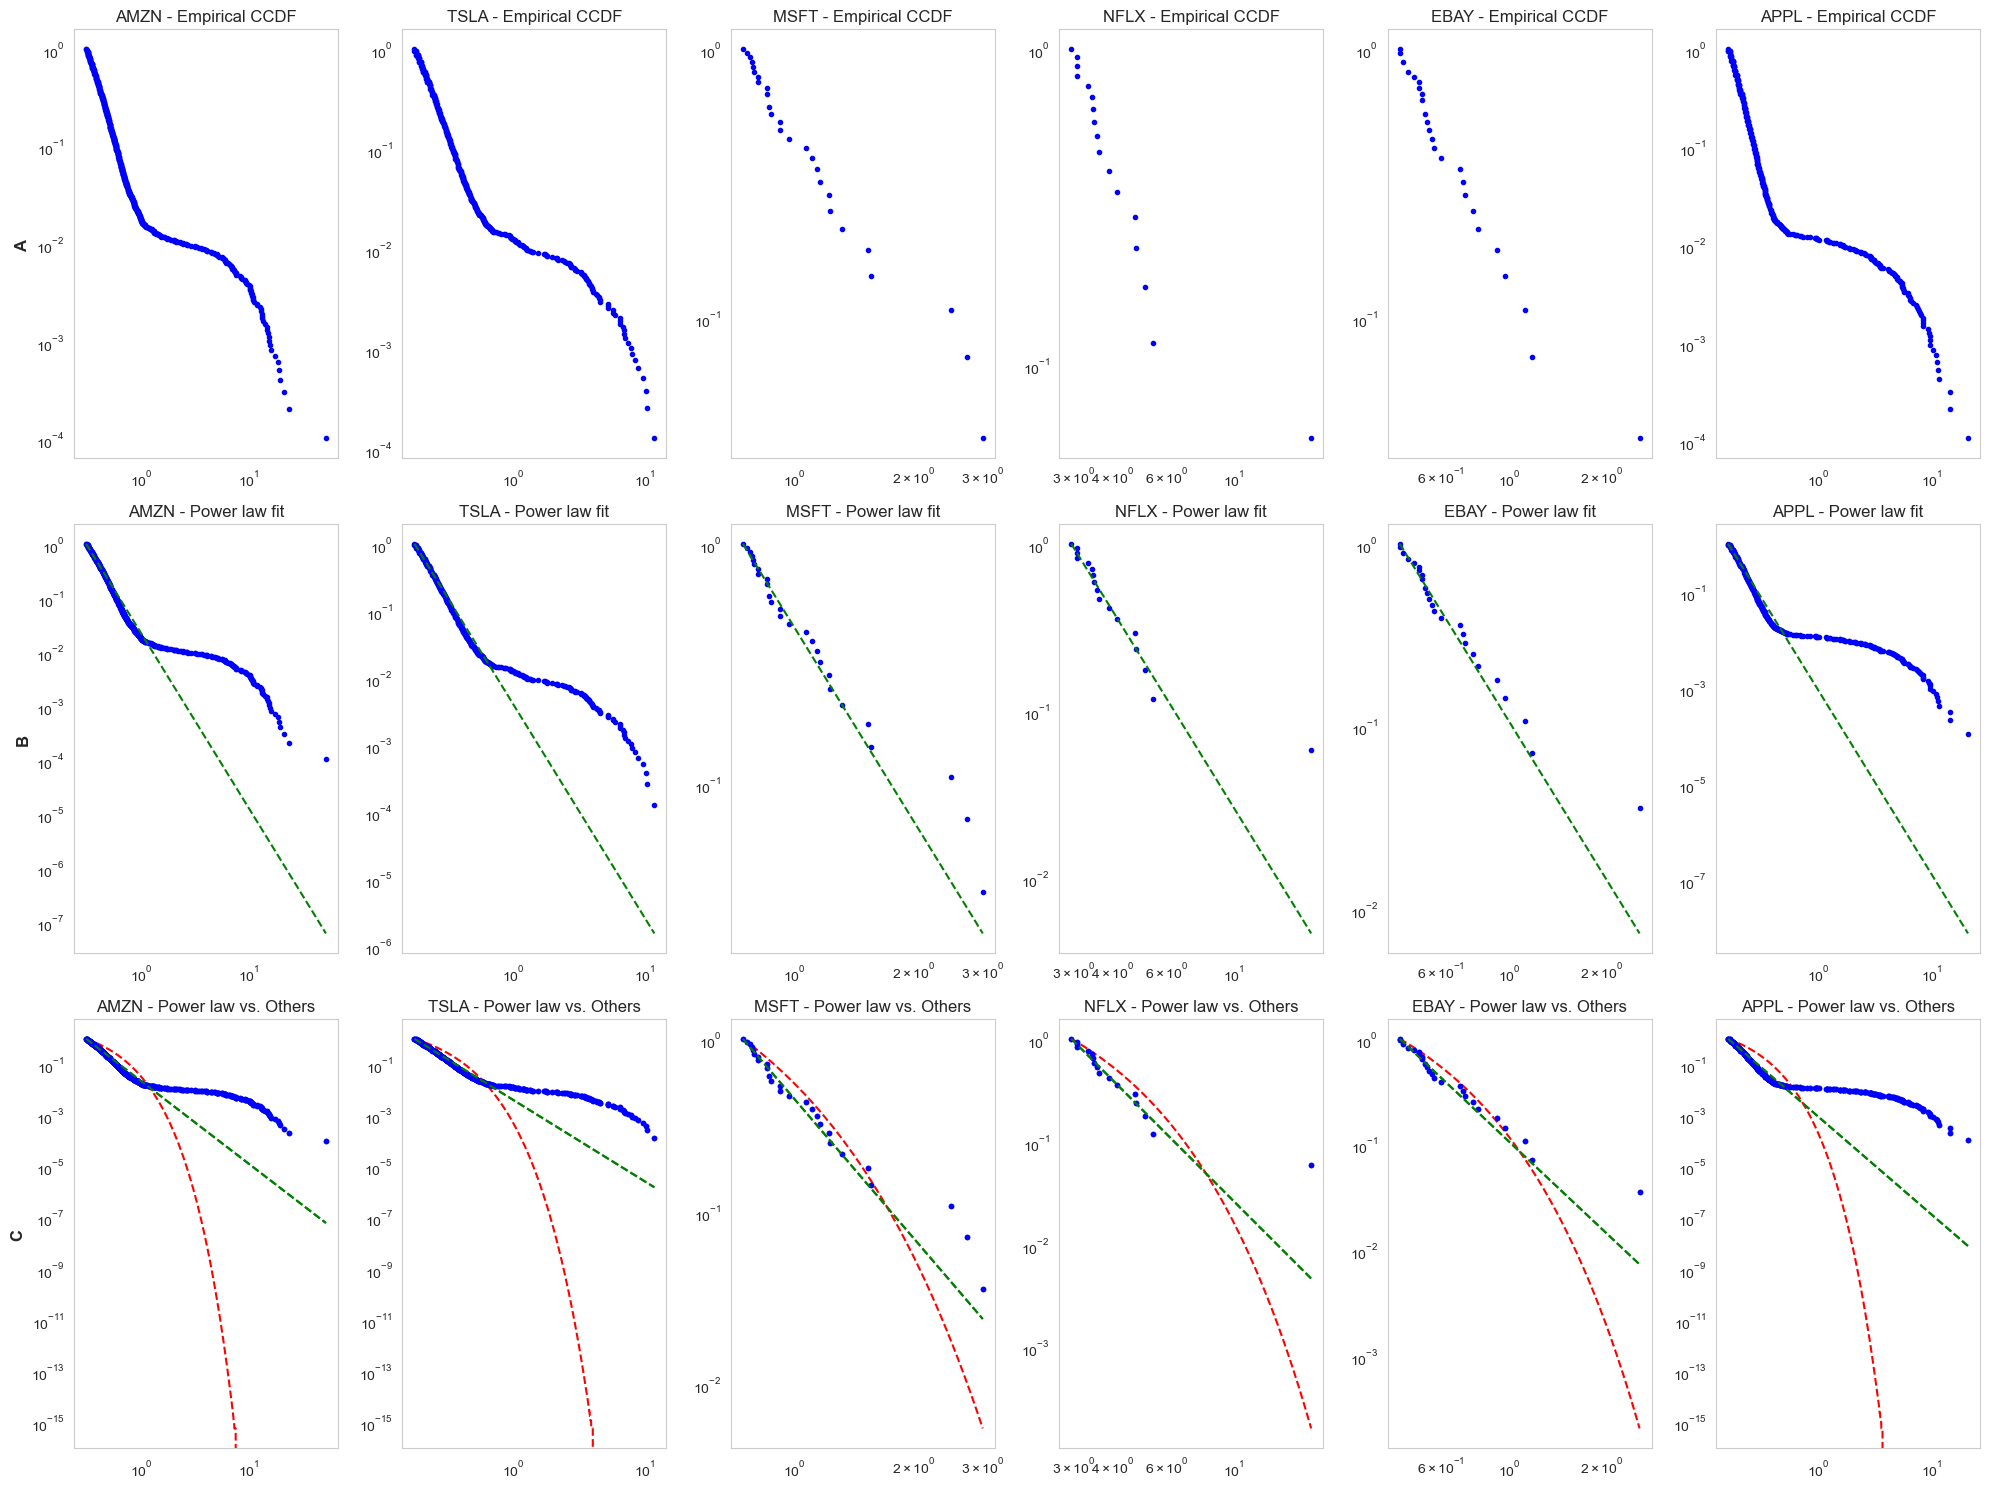

In [65]:
# Power law vs exponential for all stocks
fig, axs = plt.subplots(3, len(fit_objects), figsize=(20, 15))

for i, (stock_name, fit) in enumerate(fit_objects.items()):
    """
    Left to Right: Figure A shows cumulative distribution functions of example datasets. Figur B shows how only a portion of the distribution’s tail may follow a power law. Figure C shows how the goodness of the power law fit should be compared to alternatives
    """
    # Row 1: Empirical CCDF
    empirical_data = fit.ccdf()
    axs[0, i].loglog(empirical_data[0], empirical_data[1], 'b.')
    axs[0, i].set_title(f'{stock_name} - Empirical CCDF')
    axs[0, i].grid(False)
    if i == 0:
        axs[0, i].set_ylabel('A', size='large', weight='bold')

    # Row 2: Empirical data and power law fit
    x = np.linspace(min(fit.data), max(fit.data), num=1000)
    y = fit.power_law.ccdf(x)
    axs[1, i].loglog(empirical_data[0], empirical_data[1], 'b.')
    axs[1, i].loglog(x, y, 'g--')
    axs[1, i].set_title(f'{stock_name} - Power law fit')
    axs[1, i].grid(False)
    if i == 0:
        axs[1, i].set_ylabel('B', size='large', weight='bold')

    # Row 3: Comparison to exponential distribution
    exponential_fit = powerlaw.Fit(fit.data, discrete=False, xmin=min(fit.data), estimate_discrete=False).exponential
    y_exp = exponential_fit.ccdf(x)
    axs[2, i].loglog(empirical_data[0], empirical_data[1], 'b.')
    axs[2, i].loglog(x, y, 'g--')
    axs[2, i].loglog(x, y_exp, 'r--')
    axs[2, i].set_title(f'{stock_name} - Power law vs. Others')
    axs[2, i].grid(False)
    if i == 0:
        axs[2, i].set_ylabel('C', size='large', weight='bold')

    # Row 4: Comparison to lognormal distribution
    lognormal_fit = powerlaw.Fit(fit.data, discrete=False, xmin=min(fit.data), estimate_discrete=False).lognormal
    y_exp = lognormal_fit.ccdf(x)
    axs[2, i].loglog(empirical_data[0], empirical_data[1], 'b.')
    axs[2, i].loglog(x, y, 'g--')
    axs[2, i].loglog(x, y_exp, 'y--')
    axs[2, i].set_title(f'{stock_name} - Power law vs. Others')
    axs[2, i].grid(False)
    if i == 0:
        axs[2, i].set_ylabel('C', size='large', weight='bold')

plt.tight_layout()
plt.show()

## 4.1. Retrieve all fitted parameters

In [62]:
def return_all_fitting_params(fit_objects):
    fit_results = []
    distributions = ['power_law', 'lognormal', 'exponential', 'truncated_power_law', 'stretched_exponential', 'lognormal_positive']
    parameter_names = {
        'power_law': ['alpha'],
        'lognormal': ['mu', 'sigma'],
        'exponential': ['Lambda'],
        'truncated_power_law': ['alpha', 'Lambda', 'xmin'],
        'stretched_exponential': ['Lambda', 'beta'],
        'lognormal_positive': ['mu', 'sigma']
    }

    for stock_name, fit in fit_objects.items():
        for dist in distributions:
            try:
                if dist == 'truncated_power_law':
                    parameters = fit.truncated_power_law.alpha, fit.truncated_power_law.Lambda, fit.truncated_power_law.xmin
                elif dist == 'power_law':
                    parameters = fit.power_law.alpha,
                elif dist == 'lognormal':
                    parameters = fit.lognormal.mu, fit.lognormal.sigma
                elif dist == 'exponential':
                    parameters = fit.exponential.Lambda,
                elif dist == 'stretched_exponential':
                    parameters = fit.stretched_exponential.Lambda, fit.stretched_exponential.beta
                elif dist == 'lognormal_positive':
                    parameters = fit.lognormal_positive.mu, fit.lognormal_positive.sigma
                xmin = fit.xmin
                KS = getattr(fit, dist).D
                R, p = fit.distribution_compare('power_law', dist, normalized_ratio=True)
            except (AttributeError, TypeError):
                parameters = [np.nan]
                xmin = np.nan
                KS = np.nan
                R = np.nan
                p = np.nan
            result = [stock_name, dist] + list(parameters) + [xmin, KS, R, p]
            result_dict = {name: value for name, value in zip(['Stock', 'Distribution'] + parameter_names[dist] + ['xmin', 'KS Distance', 'Loglikelihood Ratio', 'p-value'], result)}
            fit_results.append(result_dict)

    df = pd.DataFrame(fit_results)
    return df

In [63]:
df = return_all_fitting_params(fit_objects)
df

Assuming nested distributions
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/powerlaw.py:1818: RuntimeWarning: invalid value encountered in double_scalars
  R = R/sqrt(n*variance)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
No valid fits found.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distri

,Stock,Distribution,alpha,xmin,KS Distance,Loglikelihood Ratio,p-value,mu,sigma,Lambda,beta
0,AMZN,power_law,4.225545,0.305,0.031444,NaN,1.000000e+00,NaN,NaN,NaN,NaN
1,AMZN,lognormal,NaN,0.305,NaN,1.722044,8.506147e-02,-4.531539e+02,11.872976,NaN,NaN
2,AMZN,exponential,NaN,0.305,0.231032,10.412466,2.175127e-25,NaN,NaN,4.939013e+00,NaN
3,AMZN,truncated_power_law,4.225511,0.305,0.031447,0.001937,9.982028e-01,NaN,NaN,3.118059e-09,NaN
4,AMZN,stretched_exponential,NaN,0.305,0.043434,9.008568,2.087651e-19,NaN,NaN,2.579146e+09,0.147074
5,AMZN,lognormal_positive,NaN,0.305,0.999898,42382.123300,0.000000e+00,-8.774183e-01,0.391272,NaN,NaN
6,TSLA,power_law,4.168750,0.175,0.046951,NaN,1.000000e+00,NaN,NaN,NaN,NaN
7,TSLA,lognormal,NaN,0.175,NaN,-0.199882,8.415727e-01,-4.638266e+02,12.098829,NaN,NaN
8,TSLA,exponential,NaN,0.175,0.203513,9.694856,3.170851e-22,NaN,NaN,9.242861e+00,NaN
9,TSLA,truncated_power_law,4.168751,0.175,0.046951,0.207223,9.969550e-01,NaN,NaN,3.406089e-08,NaN
